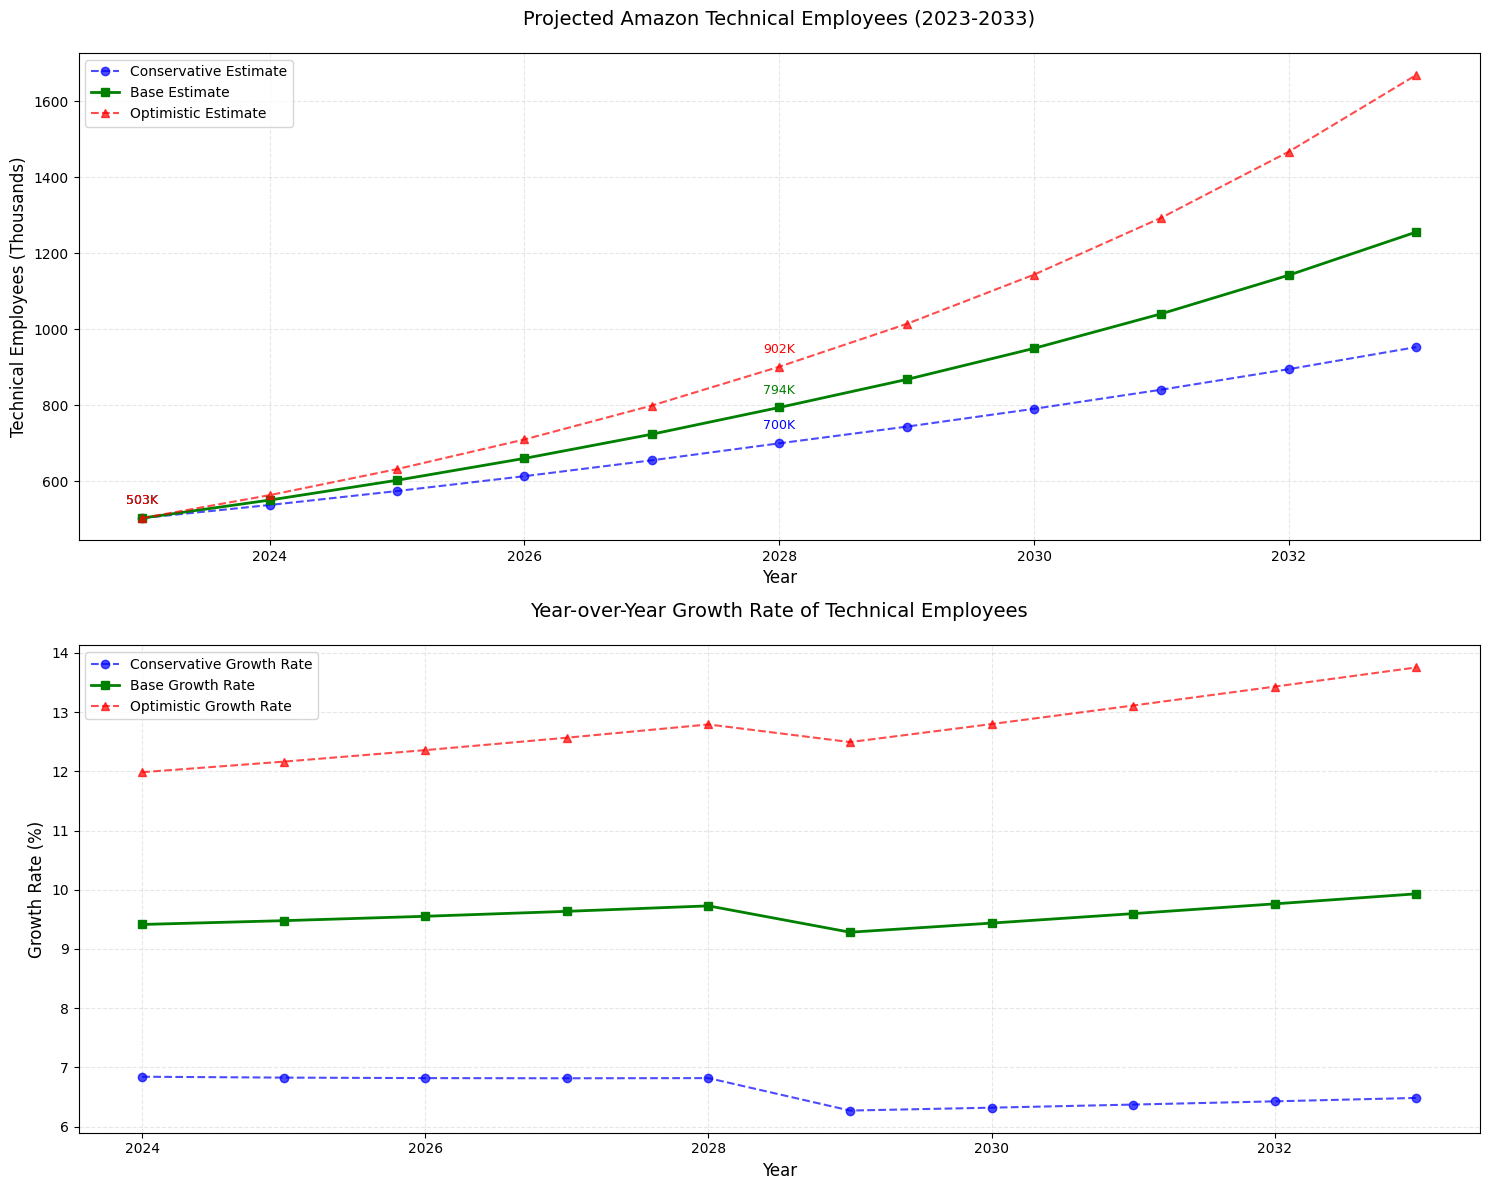


Technical Employee Projections Summary
--------------------------------------------------
Starting Technical Employees (2023):
Amazon_US: 308,000
Amazon_International: 66,000
AWS: 129,200
Total: 503,200

Projected Technical Employees by 2033:

Amazon_US:
Conservative: 469,313
Base: 543,081
Optimistic: 627,124

Amazon_International:
Conservative: 141,909
Base: 179,557
Optimistic: 225,967

AWS:
Conservative: 342,167
Base: 533,690
Optimistic: 816,814

Total 2033 Projections:
Conservative: 953,389
Base: 1,256,328
Optimistic: 1,669,905


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reference Link:
# Amazon Annual Reports:
# https://ir.aboutamazon.com/annual-reports-proxies-and-shareholder-letters/default.aspx

# Starting Employee Numbers (2023)
starting_employees = {
    'Amazon_US': 1_100_000,
    'Amazon_International': 264_000,
    'AWS': 136_000
}

# Growth Rates
growth_rates = {
    'Amazon_US': {'lower': 0.02, 'median': 0.035, 'upper': 0.05},
    'Amazon_International': {'lower': 0.05, 'median': 0.075, 'upper': 0.10},
    'AWS': {'lower': 0.10, 'median': 0.15, 'upper': 0.2}
}

# Tech ratio progression over years
tech_ratio_progression = {
    'Amazon_US': {
        2023: 0.28,  # Starting at 28%
        2028: 0.32,  # Increase to 32% by 2028
        2033: 0.35   # Increase to 35% by 2033
    },
    'Amazon_International': {
        2023: 0.25,  # Starting at 25%
        2028: 0.30,  # Increase to 30% by 2028
        2033: 0.33   # Increase to 33% by 2033
    },
    'AWS': {
        2023: 0.95,  # Starting at 95%
        2028: 0.96,  # Slight increase to 96% by 2028
        2033: 0.97   # Slight increase to 97% by 2033
    }
}

# Years for projection
years = np.arange(2023, 2034)

# Initialize DataFrame
df = pd.DataFrame({'Year': years})

def get_tech_ratio(year, sector):
    """Calculate tech ratio for a given year using linear interpolation"""
    progression = tech_ratio_progression[sector]
    if year in progression:
        return progression[year]
    
    # Find the surrounding years
    years = sorted(progression.keys())
    for i in range(len(years)-1):
        if years[i] <= year <= years[i+1]:
            # Linear interpolation
            ratio = (year - years[i]) / (years[i+1] - years[i])
            return progression[years[i]] + ratio * (progression[years[i+1]] - progression[years[i]])
    return progression[years[-1]]  # Return last value if beyond range

def project_employees(starting_number, rates, sector):
    """Project both total and technical employees"""
    total_projections = {'lower': [], 'median': [], 'upper': []}
    tech_projections = {'tech_lower': [], 'tech_median': [], 'tech_upper': []}
    
    # Initialize first year
    for scenario in ['lower', 'median', 'upper']:
        total_projections[scenario].append(starting_number)
        tech_projections[f'tech_{scenario}'].append(
            starting_number * get_tech_ratio(2023, sector)
        )
    
    # Project future years
    for year in years[1:]:
        for scenario in ['lower', 'median', 'upper']:
            # Calculate total employees
            prev_total = total_projections[scenario][-1]
            new_total = prev_total * (1 + rates[scenario])
            total_projections[scenario].append(new_total)
            
            # Calculate tech employees with progressive ratio
            tech_ratio = get_tech_ratio(year, sector)
            tech_projections[f'tech_{scenario}'].append(new_total * tech_ratio)
    
    return {**total_projections, **tech_projections}

# Project for each sector
for sector in starting_employees.keys():
    projections = project_employees(
        starting_employees[sector],
        growth_rates[sector],
        sector
    )
    
    # Add projections to dataframe with consistent column naming
    for scenario in ['lower', 'median', 'upper']:
        df[f'{sector}_{scenario}'] = projections[scenario]
        df[f'{sector}_tech_{scenario}'] = projections[f'tech_{scenario}']  # Changed to lowercase 'tech'

# Calculate total tech employees across all sectors
df['tech_total_lower'] = df[[f'{sector}_tech_lower' for sector in starting_employees.keys()]].sum(axis=1)
df['tech_total_median'] = df[[f'{sector}_tech_median' for sector in starting_employees.keys()]].sum(axis=1)
df['tech_total_upper'] = df[[f'{sector}_tech_upper' for sector in starting_employees.keys()]].sum(axis=1)

# Plotting code
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Total Technical Employees
ax1.plot(df['Year'], df['tech_total_lower']/1000, 'b--o', label='Conservative Estimate', alpha=0.7)
ax1.plot(df['Year'], df['tech_total_median']/1000, 'g-s', label='Base Estimate', linewidth=2)
ax1.plot(df['Year'], df['tech_total_upper']/1000, 'r--^', label='Optimistic Estimate', alpha=0.7)

# Customize first plot
ax1.set_title('Projected Amazon Technical Employees (2023-2033)', pad=20, fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Technical Employees (Thousands)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.legend(fontsize=10)

# Add value labels on the lines
for scenario, color in zip(['tech_total_lower', 'tech_total_median', 'tech_total_upper'], 
                         ['blue', 'green', 'red']):
    for i, value in enumerate(df[scenario]):
        if i in [0, 5, -1]:  # Only show values for 2023, 2028, and 2033
            ax1.annotate(f'{value/1000:,.0f}K', 
                        xy=(df['Year'][i], value/1000),
                        xytext=(0, 10), 
                        textcoords='offset points',
                        ha='center',
                        color=color,
                        fontsize=9)

# Calculate and plot growth rates
df['growth_rate_lower'] = df['tech_total_lower'].pct_change() * 100
df['growth_rate_median'] = df['tech_total_median'].pct_change() * 100
df['growth_rate_upper'] = df['tech_total_upper'].pct_change() * 100

ax2.plot(df['Year'][1:], df['growth_rate_lower'][1:], 'b--o', label='Conservative Growth Rate', alpha=0.7)
ax2.plot(df['Year'][1:], df['growth_rate_median'][1:], 'g-s', label='Base Growth Rate', linewidth=2)
ax2.plot(df['Year'][1:], df['growth_rate_upper'][1:], 'r--^', label='Optimistic Growth Rate', alpha=0.7)

# Customize second plot
ax2.set_title('Year-over-Year Growth Rate of Technical Employees', pad=20, fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Growth Rate (%)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed summary
print("\nTechnical Employee Projections Summary")
print("-" * 50)
print(f"Starting Technical Employees (2023):")
for sector in starting_employees.keys():
    tech_employees = starting_employees[sector] * tech_ratio_progression[sector][2023]
    print(f"{sector}: {tech_employees:,.0f}")
print(f"Total: {df['tech_total_median'].iloc[0]:,.0f}")

print("\nProjected Technical Employees by 2033:")
for sector in starting_employees.keys():
    print(f"\n{sector}:")
    print(f"Conservative: {df[f'{sector}_tech_lower'].iloc[-1]:,.0f}")
    print(f"Base: {df[f'{sector}_tech_median'].iloc[-1]:,.0f}")
    print(f"Optimistic: {df[f'{sector}_tech_upper'].iloc[-1]:,.0f}")

print("\nTotal 2033 Projections:")
print(f"Conservative: {df['tech_total_lower'].iloc[-1]:,.0f}")
print(f"Base: {df['tech_total_median'].iloc[-1]:,.0f}")
print(f"Optimistic: {df['tech_total_upper'].iloc[-1]:,.0f}")

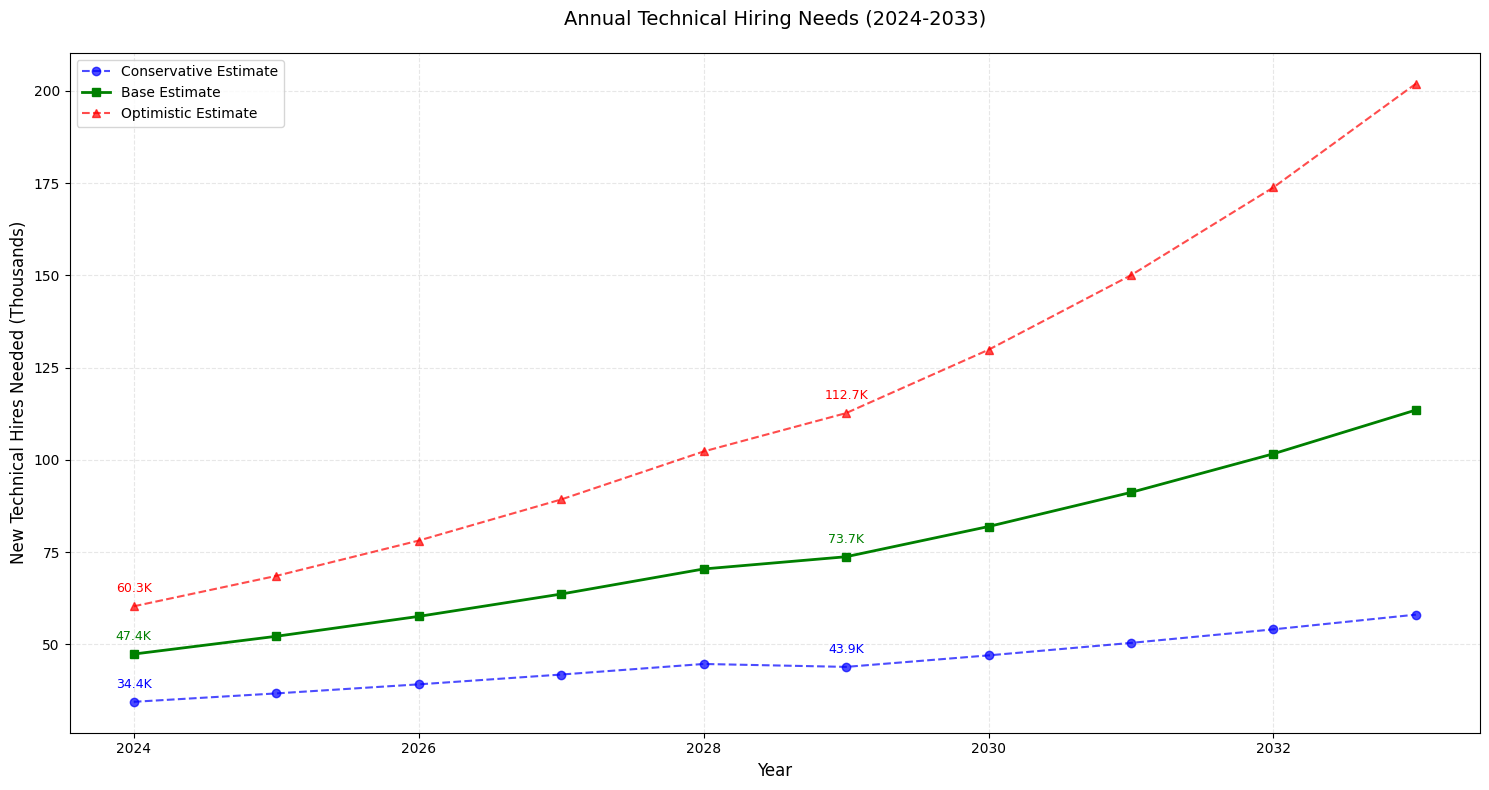


Annual Technical Hiring Needs Summary
--------------------------------------------------

By Division (2024):

Amazon_US:
Conservative: 15,136
Base: 19,888
Optimistic: 24,640

Amazon_International:
Conservative: 6,072
Base: 7,788
Optimistic: 9,504

AWS:
Conservative: 13,219
Base: 19,693
Optimistic: 26,166

Total Annual Hiring Needs:

Year 2024:
Conservative: 34,427
Base: 47,369
Optimistic: 60,310

Year 2028:
Conservative: 44,682
Base: 70,422
Optimistic: 102,260

Year 2033:
Conservative: 58,052
Base: 113,493
Optimistic: 201,918

Average Annual Hiring Needs (2024-2033):
Conservative: 45,019
Base: 75,313
Optimistic: 116,671


In [18]:
# Calculate yearly hiring needs
def calculate_hiring_needs(df):
    # Calculate year-over-year difference for each sector and scenario
    hiring_needs = pd.DataFrame({'Year': df['Year']})
    
    # For each sector
    for sector in starting_employees.keys():
        for scenario in ['lower', 'median', 'upper']:
            col_name = f'{sector}_tech_{scenario}'
            hiring_col_name = f'{sector}_hiring_{scenario}'
            hiring_needs[hiring_col_name] = df[col_name].diff()
    
    # Calculate total hiring needs across all sectors
    hiring_needs['total_hiring_lower'] = hiring_needs[[col for col in hiring_needs.columns if 'hiring_lower' in col]].sum(axis=1)
    hiring_needs['total_hiring_median'] = hiring_needs[[col for col in hiring_needs.columns if 'hiring_median' in col]].sum(axis=1)
    hiring_needs['total_hiring_upper'] = hiring_needs[[col for col in hiring_needs.columns if 'hiring_upper' in col]].sum(axis=1)
    
    return hiring_needs

hiring_needs = calculate_hiring_needs(df)

# Plotting the hiring needs
plt.figure(figsize=(15, 8))
plt.plot(hiring_needs['Year'][1:], hiring_needs['total_hiring_lower'][1:]/1000, 'b--o', 
         label='Conservative Estimate', alpha=0.7)
plt.plot(hiring_needs['Year'][1:], hiring_needs['total_hiring_median'][1:]/1000, 'g-s', 
         label='Base Estimate', linewidth=2)
plt.plot(hiring_needs['Year'][1:], hiring_needs['total_hiring_upper'][1:]/1000, 'r--^', 
         label='Optimistic Estimate', alpha=0.7)

plt.title('Annual Technical Hiring Needs (2024-2033)', pad=20, fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('New Technical Hires Needed (Thousands)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)

# Add value labels
for scenario, color in zip(['total_hiring_lower', 'total_hiring_median', 'total_hiring_upper'], 
                         ['blue', 'green', 'red']):
    for i, value in enumerate(hiring_needs[scenario][1:], 1):
        if i in [1, 6, -1]:  # Show values for 2024, 2029, and 2033
            plt.annotate(f'{value/1000:,.1f}K', 
                        xy=(hiring_needs['Year'][i], value/1000),
                        xytext=(0, 10), 
                        textcoords='offset points',
                        ha='center',
                        color=color,
                        fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed hiring needs summary
print("\nAnnual Technical Hiring Needs Summary")
print("-" * 50)
print("\nBy Division (2024):")
for sector in starting_employees.keys():
    print(f"\n{sector}:")
    print(f"Conservative: {hiring_needs[f'{sector}_hiring_lower'].iloc[1]:,.0f}")
    print(f"Base: {hiring_needs[f'{sector}_hiring_median'].iloc[1]:,.0f}")
    print(f"Optimistic: {hiring_needs[f'{sector}_hiring_upper'].iloc[1]:,.0f}")

print("\nTotal Annual Hiring Needs:")
print("\nYear 2024:")
print(f"Conservative: {hiring_needs['total_hiring_lower'].iloc[1]:,.0f}")
print(f"Base: {hiring_needs['total_hiring_median'].iloc[1]:,.0f}")
print(f"Optimistic: {hiring_needs['total_hiring_upper'].iloc[1]:,.0f}")

print("\nYear 2028:")
print(f"Conservative: {hiring_needs['total_hiring_lower'].iloc[5]:,.0f}")
print(f"Base: {hiring_needs['total_hiring_median'].iloc[5]:,.0f}")
print(f"Optimistic: {hiring_needs['total_hiring_upper'].iloc[5]:,.0f}")

print("\nYear 2033:")
print(f"Conservative: {hiring_needs['total_hiring_lower'].iloc[-1]:,.0f}")
print(f"Base: {hiring_needs['total_hiring_median'].iloc[-1]:,.0f}")
print(f"Optimistic: {hiring_needs['total_hiring_upper'].iloc[-1]:,.0f}")

# Calculate average annual hiring needs
print("\nAverage Annual Hiring Needs (2024-2033):")
print(f"Conservative: {hiring_needs['total_hiring_lower'][1:].mean():,.0f}")
print(f"Base: {hiring_needs['total_hiring_median'][1:].mean():,.0f}")
print(f"Optimistic: {hiring_needs['total_hiring_upper'][1:].mean():,.0f}")

In [2]:
def get_annual_hiring_needs(df, scenario='median'):
    """
    Calculate annual technical hiring needs based on growth and replacement
    
    Parameters:
    df: DataFrame containing projections
    scenario: 'lower', 'median', or 'upper'
    
    Returns:
    DataFrame with columns: Year, New_Hires_Growth, Replacement_Hires, Total_Hires
    """
    # Create hiring needs dataframe
    hiring_needs = pd.DataFrame()
    hiring_needs['Year'] = df['Year'][1:]  # Start from 2024
    
    # Calculate new hires needed for growth
    tech_total = df[f'tech_total_{scenario}']
    hiring_needs['New_Hires_Growth'] = tech_total.diff()[1:]  # Year-over-year increase
    
    # Calculate replacement hires (assume 10% annual turnover)
    hiring_needs['Replacement_Hires'] = tech_total[1:] * 0.10
    
    # Calculate total hiring needs
    hiring_needs['Total_Hires'] = hiring_needs['New_Hires_Growth'] + hiring_needs['Replacement_Hires']
    
    return hiring_needs

# Example usage:
hiring_needs = get_annual_hiring_needs(df, 'median')

# If you want to see the results:
print("\nAnnual Technical Hiring Needs (Base Case)")
print("-" * 50)
print(hiring_needs.to_string(float_format=lambda x: '{:,.0f}'.format(x)))


Annual Technical Hiring Needs (Base Case)
--------------------------------------------------
    Year  New_Hires_Growth  Replacement_Hires  Total_Hires
1   2024            47,369             55,057      102,426
2   2025            52,181             60,275      112,456
3   2026            57,574             66,032      123,606
4   2027            63,624             72,395      136,019
5   2028            70,422             79,437      149,859
6   2029            73,737             86,811      160,548
7   2030            81,921             95,003      176,924
8   2031            91,170            104,120      195,290
9   2032           101,636            114,283      215,920
10  2033           113,493            125,633      239,126
